## Load packages

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

## Read data

In [2]:
dar_markers=pickle.load(open('/data/leuven/351/vsc35107/lustre1_stt/data/sun/snap2_allfragments/08/Analysis_fisher_functional/data/DAR_markers_AD_dict.pkl', 'rb'))
concatenated_df = pd.concat(
    [df.assign(key=key) for key, df in dar_markers.items()],
    ignore_index=False
)
concatenated_df = concatenated_df.reset_index()
concatenated_df[['chr', 'start', 'end']] = concatenated_df['index'].str.split(':|-', expand=True)
concatenated_df['start'] = concatenated_df['start'].astype(int)
concatenated_df['end'] = concatenated_df['end'].astype(int)

concatenated_df = concatenated_df.drop(columns=['index'])
concatenated_df['start'] = concatenated_df['start'].astype(int)
concatenated_df['end'] = concatenated_df['end'].astype(int)
concatenated_df = concatenated_df[['chr', 'start', 'end'] + [col for col in concatenated_df.columns if col not in ['chr', 'start', 'end']]]
duckdb.register('peaks', concatenated_df)

In [3]:
## SNPs
parquet_file_path="/data/leuven/351/vsc35107/lustre1_stt/data/GWAS/020results_expansion/Bellenguez_etal_Stage1_result_hg38.expanded_pvalue_unique.parquet"
snps=duckdb.read_parquet(parquet_file_path)

In [4]:
query=f"""
SELECT
    pk.chr,
    pk.start,
    pk.key,
    pk.Log2FC,
    pk.Adjusted_pval,
    s.start_pos,
    s.snp_pos,
    s.rsid,
    s.p_val
FROM
    snps s
JOIN
    peaks pk ON s.chromosome = pk.chr
                      AND s.start_pos BETWEEN pk.start AND pk.end;
"""
snps_peaks_joined_table=duckdb.query(query).df()

print(sum(snps_peaks_joined_table.duplicated()))
snps_peaks_joined_table=snps_peaks_joined_table.drop_duplicates()
print(snps_peaks_joined_table.shape)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

652
(201142, 9)


In [5]:
snps_peaks_joined_table.head()

,chr,start,key,Log2FC,Adjusted_pval,start_pos,snp_pos,rsid,p_val
0,chr1,11814546,nonAD,-0.0031,0.998175,11814797,11814798,rs149393118,0.06243
1,chr1,11814546,nonAD,-0.0031,0.998175,11814797,11814798,rs149393118,0.09582
2,chr1,11814546,nonAD,-0.0031,0.998175,11814797,11814798,rs149393118,0.07943
3,chr1,11814546,nonAD,-0.0031,0.998175,11814797,11814798,rs149393118,0.06665
4,chr1,11814546,nonAD,-0.0031,0.998175,11814797,11814798,rs149393118,0.06328


In [6]:
snps_peaks_joined_table['-log_pval'] = -np.log10(snps_peaks_joined_table['p_val'] + 1e-10)  

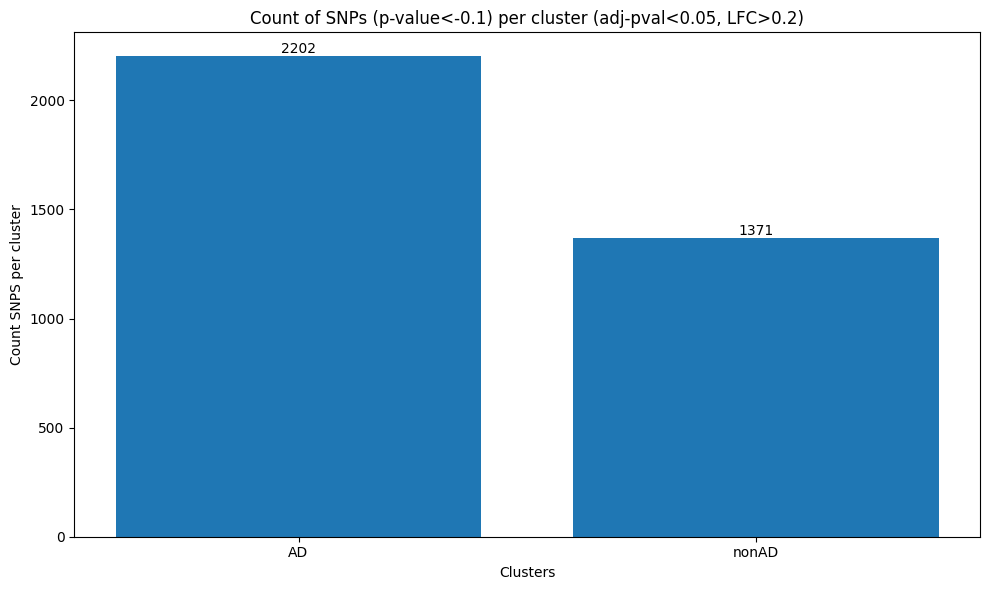

In [8]:
counts = snps_peaks_joined_table[(snps_peaks_joined_table['Log2FC'] > 0.2)&(snps_peaks_joined_table['Adjusted_pval'] <0.05)]['key'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(10, 6))
bars=plt.bar(counts.index, counts.values)

# Add labels, title, and custom tick labels
plt.xlabel('Clusters')
plt.ylabel('Count SNPS per cluster')
plt.title('Count of SNPs (p-value<-0.1) per cluster (adj-pval<0.05, LFC>0.2)')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), va='bottom', ha='center')
# Display the plot
plt.tight_layout()
plt.show()

## explore

In [42]:
df=snps_peaks_joined_table[(snps_peaks_joined_table['Log2FC'] > 0.2)&(snps_peaks_joined_table['Adjusted_pval'] <0.05)]

NameError: name 'snps_peaks_joined_table' is not defined

In [10]:
df.shape

(3573, 10)

In [11]:
df[df['rsid'] == '.'].shape

(160, 10)

In [12]:
df=df[df['rsid'] != '.']
df.shape

(3413, 10)

## DARs from clusters

In [13]:
dar_markers=pickle.load(open('/data/leuven/351/vsc35107/lustre1_stt/data/sun/snap2_allfragments/08/Analysis_fisher_functional/data/DAR_markers_dict.pkl', 'rb'))
concatenated_df = pd.concat(
    [df.assign(key=key) for key, df in dar_markers.items()],
    ignore_index=False
)
concatenated_df = concatenated_df.reset_index()
concatenated_df[['chr', 'start', 'end']] = concatenated_df['index'].str.split(':|-', expand=True)
concatenated_df['start'] = concatenated_df['start'].astype(int)
concatenated_df['end'] = concatenated_df['end'].astype(int)

concatenated_df = concatenated_df.drop(columns=['index'])
concatenated_df['start'] = concatenated_df['start'].astype(int)
concatenated_df['end'] = concatenated_df['end'].astype(int)
concatenated_df = concatenated_df[['chr', 'start', 'end'] + [col for col in concatenated_df.columns if col not in ['chr', 'start', 'end']]]
duckdb.register('peaks_clusters', concatenated_df)

In [14]:
query=f"""
SELECT
    pk.chr,
    pk.start,
    pk.key,
    pk.Log2FC,
    pk.Adjusted_pval,
    s.start_pos,
    s.snp_pos,
    s.rsid,
    s.p_val
FROM
    snps s
JOIN
    peaks_clusters pk ON s.chromosome = pk.chr
                      AND s.start_pos BETWEEN pk.start AND pk.end;
"""
snps_peaks_clusters=duckdb.query(query).df()

print(sum(snps_peaks_clusters.duplicated()))
snps_peaks_clusters=snps_peaks_clusters.drop_duplicates()
print(snps_peaks_clusters.shape)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

2934
(905139, 9)


In [15]:
dff=snps_peaks_clusters[(snps_peaks_clusters['Log2FC'] > np.log2(1.5))&(snps_peaks_clusters['Adjusted_pval'] <0.05)]

In [16]:
dff=dff[dff['rsid'] != '.']
dff.shape

(52569, 9)

In [17]:
del snps_peaks_clusters

In [18]:
del snps_peaks_joined_table

## venn diagram

In [21]:
from matplotlib_venn import venn2, venn3

In [22]:
ad=df.loc[df['key']=='AD',:]['rsid'].tolist()
nonad=df.loc[df['key']=='nonAD',:]['rsid'].tolist()

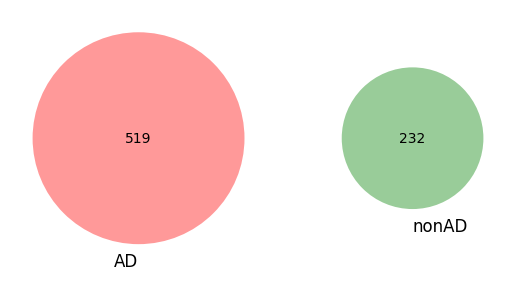

In [23]:
venn2([set(ad), set(nonad)], set_labels = ('AD', 'nonAD'))

In [24]:
def show_venn(cluster_num):
    cluster=dff.loc[dff['key']==cluster_num,:]['rsid'].tolist()
    venn3([set(ad), set(nonad), set(cluster)], set_labels = ('AD', 'nonAD', f'Cluster{cluster_num}'))

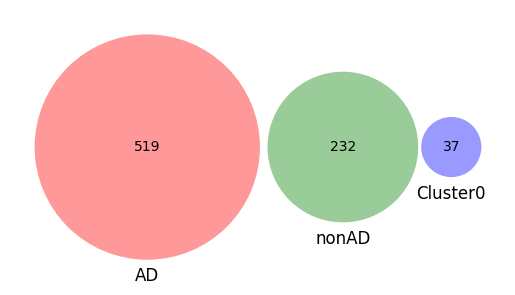

In [25]:
show_venn('0')

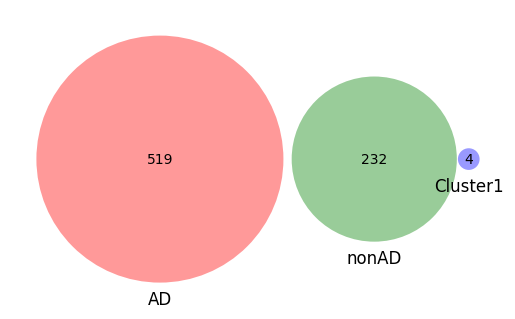

In [26]:
show_venn('1')

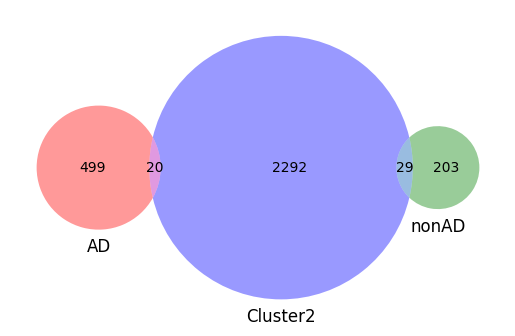

In [27]:
show_venn('2')

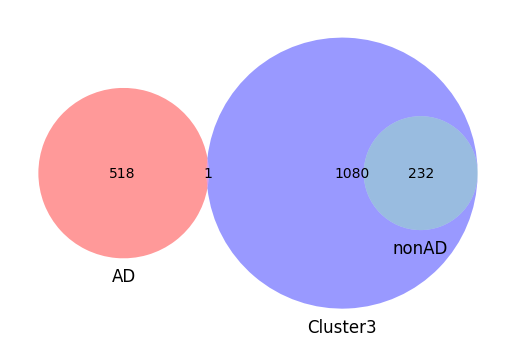

In [28]:
show_venn('3')

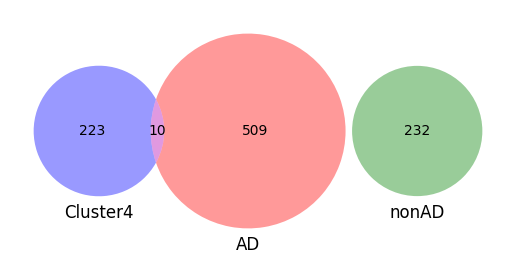

In [29]:
show_venn('4')

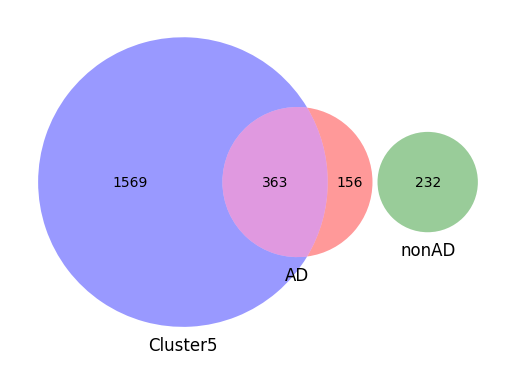

In [30]:
show_venn('5')

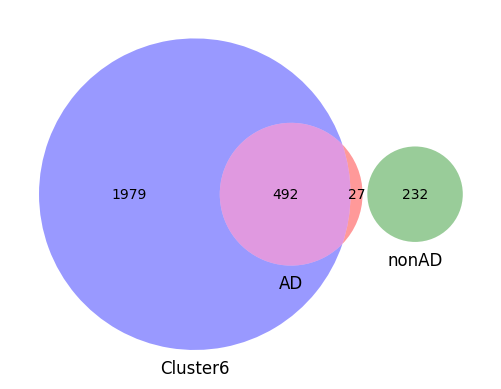

In [31]:
show_venn('6')

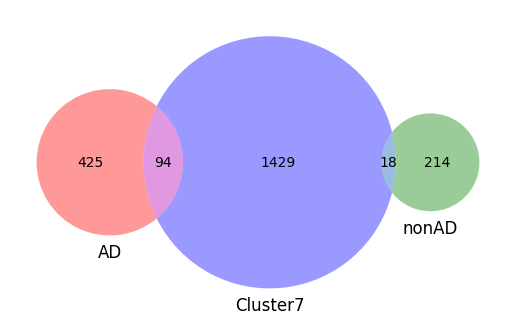

In [32]:
show_venn('7')

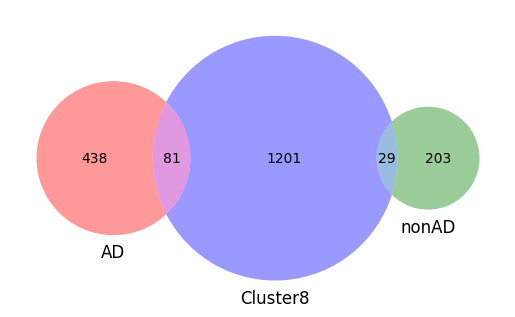

In [33]:
show_venn('8')

## correlation

In [34]:
all=pd.concat([df,dff])

In [35]:
all.key.unique()

array(['nonAD', 'AD', '2', '8', '5', '6', '7', '3', '1', '0', '4'],
      dtype=object)

In [36]:
all.head()

,chr,start,key,Log2FC,Adjusted_pval,start_pos,snp_pos,rsid,p_val,-log_pval
1109,chr1,109788111,nonAD,0.258099,1.222280e-35,109788604,109788605,rs72705270,0.08087,1.092213
1121,chr1,109822328,AD,0.205949,1.754651e-63,109822422,109822423,rs6660031,0.06465,1.189431
1122,chr1,109822328,AD,0.205949,1.754651e-63,109822422,109822423,rs6660031,0.06447,1.190642
1123,chr1,109822328,AD,0.205949,1.754651e-63,109822422,109822423,rs6660031,0.06474,1.188827
1124,chr1,109822328,AD,0.205949,1.754651e-63,109822422,109822423,rs6660031,0.06507,1.186619


In [37]:
unique_rsids = all['rsid'].unique()
unique_keys = all['key'].unique()
result_df = pd.DataFrame(0, index=unique_rsids, columns=unique_keys)
for key in unique_keys:
    key_rsids = all[all['key'] == key]['rsid']
    result_df.loc[key_rsids, key] = 1

In [38]:
result_df.shape

(7828, 11)

In [39]:
result_df.head()

,nonAD,AD,2,8,5,6,7,3,1,0,4
rs72705270,1,0,0,0,0,0,0,1,0,0,0
rs6660031,0,1,0,0,0,1,0,0,0,0,0
rs74113161,1,0,0,0,0,0,0,1,0,0,0
rs555438661,1,0,0,0,0,0,0,1,0,0,0
rs2495050,0,1,0,0,0,1,0,0,0,0,0


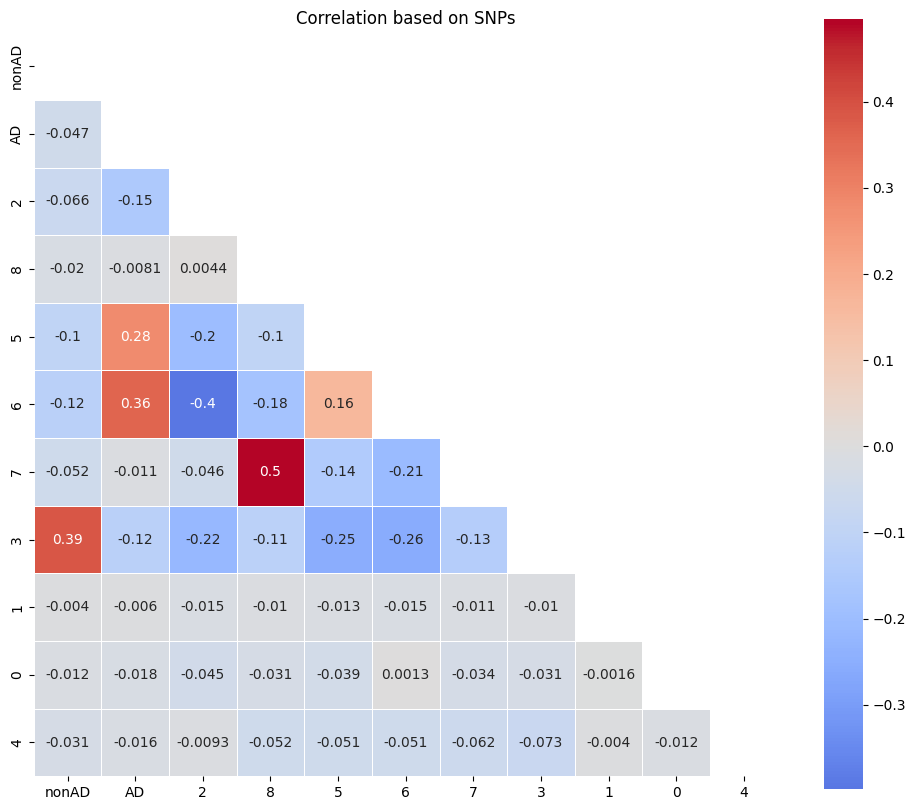

In [40]:
corr=result_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))

sns.heatmap(corr, mask=mask, cmap="coolwarm", annot=True, square=True, linewidths=.5, center=0)
plt.title('Correlation based on SNPs')
# Show the plot
plt.show()

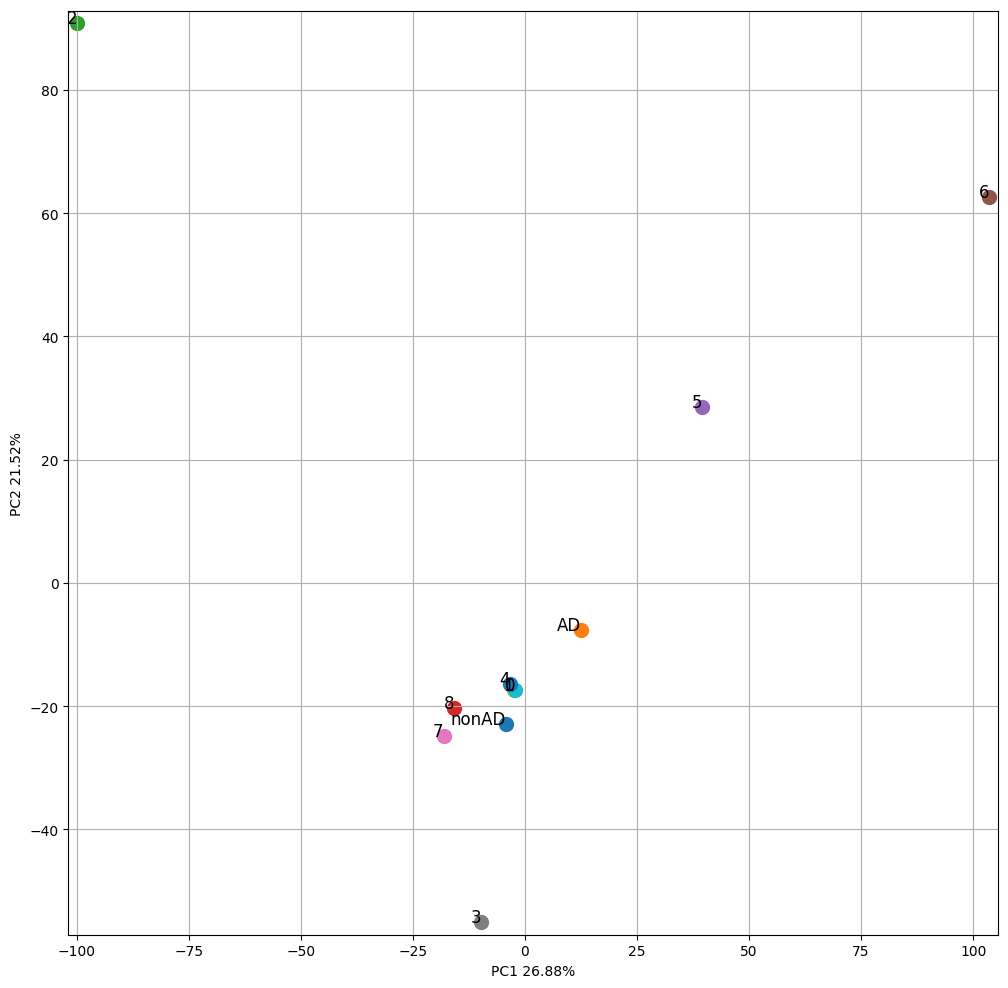

In [41]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_data = scaler.fit_transform(result_df.T)

# Perform PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
principal_df = pd.DataFrame(data=principal_components, index=result_df.columns, columns=['PC1', 'PC2'])

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))

# Plot points and add text labels
for name, row in principal_df.iterrows():
    plt.scatter(row.PC1, row.PC2, marker='o', s=100)  # s=100 for larger points
    plt.text(row.PC1, row.PC2, name, fontsize=12, ha='right')

# Set limits
plt.xlim(principal_df.PC1.min() - 2, principal_df.PC1.max() + 2)
plt.ylim(principal_df.PC2.min() - 2, principal_df.PC2.max() + 2)

# Add explained variance ratio to labels
explained_variance_ratio = pca.explained_variance_ratio_
plt.xlabel(f'PC1 {100*explained_variance_ratio[0]:.2f}%')
plt.ylabel(f'PC2 {100*explained_variance_ratio[1]:.2f}%')

# Show the plot
plt.grid()
plt.show()